# Data Science | Lab: Image Processing
**Table of Contents:**  <a name="toc"></a>
1. [Bag of Visual Words](#bovw)
2. [Histogram of Visual Words](#hovw)
3. [Image Classification](#classification)

# Bag of Visual Words
Analogous to the Bag of Words technique which we covered in the last lab, we will extract "visual" words in order to classify images in this session regarding image processing.

<a name="bovw"></a>
<div style="width: 500px; text-align: center;">
    <img src="https://customers.pyimagesearch.com/wp-content/uploads/2015/09/bovw_image_example.jpg"/>
    <a href="https://customers.pyimagesearch.com/the-bag-of-visual-words-model/" style="">Source</a>
</div>

In [15]:
%pip install opencv-contrib-python
%pip install imutils

import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy.cluster.vq import vq
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score
import imutils
import cv2

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Constructing the dataset
- Download the dataset from moodle and extract it into the folder your notebook is in (or adapt the ``directory`` below).
- More information on the Caltech 101 dataset, which contains images of objects belonging to 101 categories, can be found [here](https://data.caltech.edu/records/mzrjq-6wc02).
- Before you start diving into the task, have a look at the datasets' structure and select three different types of images you want to use in this lab session.
- Save the names of the image classes you want to use in ``use_classes``.
- Iterate over all the directories holding images of the classes you chose and save the image paths to variable ``X_paths``.
- For each image path in ``X_paths``, we need its corresponding label saved to ``y``.

In [2]:
# Define the image source folder
directory = "101_ObjectCategories"
# Choose three different classes individually
use_classes = [
    "barrel",
    "cannon",
    "crab"
]

In [3]:
# This variable will store paths to each image ->  remains empty
X_paths = []
# This variable will store class id as label ->  remains empty
y = []

In [4]:
# TODO:
# - iterate over the classes you chose
# - select all image paths that are present in the respective folders corresponding to these classes
#     - add those paths in X_paths
# - for each image you added to X_paths this way, save an instance of its class id to y

for class_id, class_name in enumerate(use_classes):
    class_folder = os.path.join(directory, class_name)
    if os.path.isdir(class_folder):
        for file_name in sorted(os.listdir(class_folder)):
            if file_name.lower().endswith(('jpg', 'jpeg', 'png')):  # Ensure valid image formats
                image_path = os.path.join(class_folder, file_name)
                X_paths.append(image_path)
                y.append(class_id)  # Use class index as label

# Display the collected image paths and labels
print(f"Collected {len(X_paths)} image paths.")
print(f"Collected {len(y)} labels.")
print(X_paths)

Collected 163 image paths.
Collected 163 labels.
['101_ObjectCategories/barrel/image_0001.jpg', '101_ObjectCategories/barrel/image_0002.jpg', '101_ObjectCategories/barrel/image_0003.jpg', '101_ObjectCategories/barrel/image_0004.jpg', '101_ObjectCategories/barrel/image_0005.jpg', '101_ObjectCategories/barrel/image_0006.jpg', '101_ObjectCategories/barrel/image_0007.jpg', '101_ObjectCategories/barrel/image_0008.jpg', '101_ObjectCategories/barrel/image_0009.jpg', '101_ObjectCategories/barrel/image_0010.jpg', '101_ObjectCategories/barrel/image_0011.jpg', '101_ObjectCategories/barrel/image_0012.jpg', '101_ObjectCategories/barrel/image_0013.jpg', '101_ObjectCategories/barrel/image_0014.jpg', '101_ObjectCategories/barrel/image_0015.jpg', '101_ObjectCategories/barrel/image_0016.jpg', '101_ObjectCategories/barrel/image_0017.jpg', '101_ObjectCategories/barrel/image_0018.jpg', '101_ObjectCategories/barrel/image_0019.jpg', '101_ObjectCategories/barrel/image_0020.jpg', '101_ObjectCategories/barrel/i

### Train/Test split
- Perform a train/test split of the dataset (``X`` being image paths, ``y`` being corresponding labels) you constructed.
- Use 80% of data to train the model.
- Be sure to use stratified sampling since not all categories consist of equal number of images.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_paths,  # List of image paths
    y,        # List of corresponding labels
    test_size=0.2,
    stratify=y,  # Preserve class distribution
    random_state=42  # For reproducibility
)

# Verify split sizes
print(f"Total samples: {len(X_paths)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Class distribution in training set: {np.unique(y_train, return_counts=True)}")
print(f"Class distribution in test set: {np.unique(y_test, return_counts=True)}")

Total samples: 163
Training samples: 130
Test samples: 33
Class distribution in training set: (array([0, 1, 2]), array([38, 34, 58]))
Class distribution in test set: (array([0, 1, 2]), array([ 9,  9, 15]))


### Extract SIFT Features
- Use ``cv2`` ([OpenCV](https://docs.opencv.org/4.9.0/index.html)) to extract meaningful features from images.
- Loop through the image paths you saved in your training set and extract the descriptors of found keypoints using the ``detectAndCompute()`` method of OpenCV's SIFT implementation as described [here](https://docs.opencv.org/4.9.0/d0/d13/classcv_1_1Feature2D.html#a8be0d1c20b08eb867184b8d74c15a677).
- For more information on how to use SIFT in OpenCV, check this [tutorial](https://docs.opencv.org/4.9.0/da/df5/tutorial_py_sift_intro.html).

In [6]:
def extract_features(image_paths):
    desc_list = []
    sift = cv2.SIFT_create()  # Create a SIFT object

    for image_path in image_paths:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
        kp, des = sift.detectAndCompute(img, None)  # Detect keypoints and compute descriptors
        if des is not None:  # Check if descriptors were found
            desc_list.append(des)
        else:
            # Handle cases where no descriptors are found
            # For example, append an empty array or skip the image
            print(f"Warning: No descriptors found for {image_path}")
            desc_list.append(np.array([]))

    return desc_list

In [7]:
train_desc_list = extract_features(X_train)

### Clustering
- We want to assign similar descriptors to clusters that represent the idea of visual words in our images.
- To do this, use the K-Means clustering method to extract clusters of descriptors from the descriptors found in all images of the training set.
    - If you want to use [sklearn's](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) K-Means implementation, you need to parameterize it to reduce runtime (i.e., set ``n_init``, minimize ``max_iter``).
    - You can also rely on [OpenCV](https://docs.opencv.org/4.x/d1/d5c/tutorial_py_kmeans_opencv.html), as it provides a faster implementation of K-Means.
- In any case, we want to set ``k=100`` as the number of clusters that are to be applied to the keypoint descriptors computed by SIFT.

<div class="alert alert-block alert-info">
    <b>Caution:</b> As we applied SIFT feature extraction to each image individually, you will have to flatten <tt>train_desc_list</tt> in order to perform the clustering correctly.
</div>

In [8]:
# TODO: Stack all the descriptors of train_desc_list vertically in a numpy array
train_descriptors = np.vstack(train_desc_list)

In [9]:
k = 100  # Number of clusters
#criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
#flags = cv2.KMEANS_RANDOM_CENTERS
#compactness, labels, centers = cv2.kmeans(train_descriptors.astype(np.float32), k, None, criteria, 10, flags)

from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state=42)
kmeans_model.fit(train_descriptors)

KMeans(max_iter=100, n_clusters=100, n_init=10, random_state=42)

# Histogram of Visual Words
- In the next step, we want to apply the trained K-Means model to the descriptors of each image individually.
- This way, we create a histogram denoting counts of feature clusters for every single image.
- Think about it this way:
    - Before this step, the number of descriptors found by SIFT may be different for each image.
    - After we apply K-Means to each set of descriptors of a image, every image has a vector of length ``k`` that describes the visual words found in this image as they were computed from the whole training set.

<a name="hovw"></a>
<div style="width: 500px; text-align: center;">
    <img src="https://miro.medium.com/max/625/1*QgI1t-7yJApi4vQigFgsLQ.jpeg"/>
    <a href="https://towardsdatascience.com/bag-of-visual-words-in-a-nutshell-9ceea97ce0fb" style="">Source</a>
</div>

### Constructing histogram with ``compute_feature_histogram(...)``
- Suppose we set ``k=100`` and therefore computed 100 clusters from the descriptor list and we have 250 images in the training dataset.
- ``compute_feature_histogram(...)`` should create a vector for each image (250 in this example) containing ``k=100`` elements.
- Hence the shape of its return value will be ``(250, 100)``.
- Remember that every image contains an arbitary number of descriptors found in it, thus we need to loop over the images separately to compute each histogram correctly.
- Be sure to also apply the construction of histograms to your test set as well!
- You may need to apply ``extract_features(...)`` to your testing set if you did not do so already.

In [10]:
def compute_feature_histogram(_model, _desc_list, _k):
    # Compute feature histogram
    _bovw_features = np.zeros((len(_desc_list), _k), "float32")
    for i, descr in enumerate(_desc_list):
        labels = _model.predict(descr)
        (hist, _) = np.histogram(labels, bins=range(_k + 1), density=True)
        _bovw_features[i] = hist
    return _bovw_features

In [11]:
train_bovw_features = compute_feature_histogram(kmeans_model, train_desc_list, k) # Assuming kmeans_model is your trained KMeans model
train_bovw_features.shape
len(y_train)

130

In [12]:
test_desc_list = extract_features(X_test)
test_bovw_features = compute_feature_histogram(kmeans_model, test_desc_list, k) # Assuming kmeans_model is your trained KMeans model

# Image Classification
<a name="classification"></a>
- Finally, train a MinDist classifier on the training set and predict the category of each image in the test set.
- As always, remember that in scikit-learn, MinDist is called [Nearest Centroid](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html?highlight=nearest%20centroid#sklearn.neighbors.NearestCentroid).
- Evaluate your classifier's performance by plotting the confusion matrix!


Accuracy: 0.5757575757575758


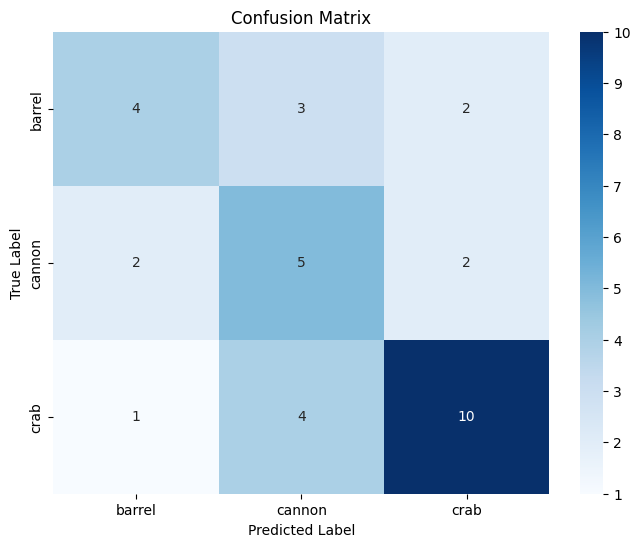

In [13]:
# TODO: implement image classification steps described above!

from sklearn.neighbors import NearestCentroid
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ... (previous code for feature extraction, clustering, and histogram computation) ...

# Train the Nearest Centroid classifier
classifier = NearestCentroid()
classifier.fit(train_bovw_features, y_train)

# Predict on the test set
y_pred = classifier.predict(test_bovw_features)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=use_classes, yticklabels=use_classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Homework Assignment

Extend your code to include the following:
1. Extend your dataset to use 5 different individually chosen categories of images.
2. Set up a grid search for at least three different ``k`` for K-Means and two different distance ``metric``s for MinDist.
3. Evaluate the grid with 3-fold (stratified) cross validation with ``accuracy`` as the scoring method.
4. Check if histogram normalization has an influence on your results by including it as an option in your grid search.
5. Plot the confusion matrix for the test dataset using the best setting according to the grid search.
6. Document your findings (see final comment in section Moodle Upload on the topics to include in your findings).


## Moodle Upload
This is an **indivdual** assignment, meaning that you are graded individually. If you have collaborated with colleagues during the lab, make sure to state **all** of their names at the beginning of the document. The final document **must** exhibit individual efforts (structure, variable settings, reasoning, interpretation) despite some inherent similarities.

Upload your notebook as ``firstname_lastname_ip.html`` to Moodle.

Make sure to consider the following:
* Have all your import statements in one single cell at the top of the notebook.
* Remove unnecessary code.
* Include a markdown cell at the end where you:
    * give a short overview of what your notebook is about
    * be sure to describe BOVW in your own words: Which steps are necessary? How does it relate to the BoW-concept from NLP? What are "words" and "documents" in this context?
    * describe and interpret your settings and justify your choices
    * analyze the final/best results

In [17]:
train_descriptors = np.vstack([desc for desc in train_desc_list if desc is not None])

# Grid search parameters
k_values = [50, 100, 150]  # Different cluster sizes
metrics = ["euclidean", "manhattan"]  # Different distance metrics
normalize_options = [True, False]  # Check impact of histogram normalization

# Perform Grid Search
best_score = 0
best_params = {}
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(train_descriptors)
    
    for metric in metrics:
        for normalize in normalize_options:
            # Compute histograms
            train_bovw_features = compute_feature_histogram(kmeans, train_desc_list, k, normalize)
            
            # Cross-validation
            skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            clf = NearestCentroid(metric=metric)
            scores = []
            for train_idx, val_idx in skf.split(train_bovw_features, y_train):
                clf.fit(train_bovw_features[train_idx], np.array(y_train)[train_idx])
                scores.append(accuracy_score(np.array(y_train)[val_idx], clf.predict(train_bovw_features[val_idx])))
            
            avg_score = np.mean(scores)
            print(f"k={k}, metric={metric}, normalize={normalize}, accuracy={avg_score:.4f}")
            
            # Store best parameters
            if avg_score > best_score:
                best_score = avg_score
                best_params = {"k": k, "metric": metric, "normalize": normalize}

# Train with best settings
best_kmeans = KMeans(n_clusters=best_params["k"], n_init=10, max_iter=300, random_state=42)
best_kmeans.fit(train_descriptors)
train_bovw_features = compute_feature_histogram(best_kmeans, train_desc_list, best_params["k"], best_params["normalize"])
test_sift_features = extract_features(X_test)
test_bovw_features = compute_feature_histogram(best_kmeans, test_sift_features, best_params["k"], best_params["normalize"])

clf = NearestCentroid(metric=best_params["metric"])
clf.fit(train_bovw_features, y_train)
y_pred = clf.predict(test_bovw_features)

# Evaluate final model
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Test Accuracy: {accuracy:.4f}")
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=use_classes, yticklabels=use_classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Document findings
print("Best Parameters:", best_params)
print("Final Accuracy:", accuracy)

k=50, metric=euclidean, normalize=True, accuracy=0.5391
k=50, metric=euclidean, normalize=False, accuracy=0.5391
k=50, metric=manhattan, normalize=True, accuracy=0.5548
k=50, metric=manhattan, normalize=False, accuracy=0.5548
k=100, metric=euclidean, normalize=True, accuracy=0.6163
k=100, metric=euclidean, normalize=False, accuracy=0.6163
k=100, metric=manhattan, normalize=True, accuracy=0.6011
k=100, metric=manhattan, normalize=False, accuracy=0.6011
k=150, metric=euclidean, normalize=True, accuracy=0.6082
k=150, metric=euclidean, normalize=False, accuracy=0.6082
k=150, metric=manhattan, normalize=True, accuracy=0.5930
k=150, metric=manhattan, normalize=False, accuracy=0.5930


TypeError: compute_feature_histogram() takes 3 positional arguments but 4 were given